# Radiation model

This model is based on a diffusion process in which an
object in a specific location emits particles, having nearby objects with a different probability of absorbing these
particles, which varies according to the forces acting upon them.
<br>
In the context of commuters, the objects are the
cities, and the particles are the people commuting. Thus, cities are radiating commuters, which are absorbed by
neighboring cities.

We use the formula:
<br>
$T_{st}= T_s\frac{m_s n_t}{(m_s + p_{st})(m_s + n_t + p_{st})}$
<br>
$T_{st}$ = number of commuters from commune s to commune t
<br>
$m_s$ = population of commune s
<br>
$n_t$ = population of commune t
<br>
$p_{st}$ = total population in the circle of radius $r_{st}$ centered at city s
<br>
$T_s$ = scaling factor of the outgoing number of commuters from the source city

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import os
from functions import *


In [5]:
base_path = '/Users/leilapaolini/Documents/Data for project 2'
full_path = os.path.join(base_path, 'data_y2.npy')
data = np.load(full_path, allow_pickle=True)

print(f"Data type: {type(data)}")
print(f"Data shape: {data.shape if hasattr(data, 'shape') else 'N/A'}")

Data type: <class 'numpy.ndarray'>
Data shape: (19237044, 37)


In [6]:
df = pd.DataFrame(data, columns=['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'])

df.head()


,commune_1,commune_2,distance,year,pop_1,pop_2,T_Mann,T_Frau,Etr_Total,Accidents dégâts matériels,...,BFS_NUMMER_2,GEM_FLAECH_2,EINWOHNERZ_2,0-25_2,25-65_2,65+_2,canton_code_2,unemployment_2,gdp_2,flow
0,2549.0,3762.0,211075.817922,2018.0,28.0,4591.0,15.0,13.0,0.0,0.0,...,3762.0,43863.0,4638.0,1014.0,2447.0,1233.0,18.0,1475.833333,14501.14771,0.0
1,2549.0,3762.0,211075.817922,2018.0,28.0,4591.0,15.0,13.0,0.0,0.0,...,3762.0,43863.0,4638.0,1014.0,2447.0,1233.0,18.0,1475.833333,14501.14771,0.0
2,2549.0,3762.0,211075.817922,2020.0,28.0,4591.0,17.0,15.0,164.5,0.0,...,3762.0,43861.0,4591.0,1004.0,2442.0,1292.0,18.0,2142.250000,14627.09554,0.0
3,2549.0,3762.0,211075.817922,2020.0,28.0,4591.0,17.0,15.0,164.5,0.0,...,3762.0,43861.0,4591.0,1004.0,2442.0,1292.0,18.0,2142.250000,14627.09554,0.0
4,2549.0,441.0,54686.672720,2018.0,28.0,928.0,15.0,13.0,0.0,0.0,...,441.0,1263.0,905.0,218.0,548.0,186.0,2.0,10763.750000,80775.78955,0.0


In [19]:
df_nonzero = df[df['flow'] > 0].copy()

In [78]:
def add_radius_pop(df):
    """
    Adds a column 'p_st' to the dataframe.
    For each row, p_st is the sum of populations of unique communes
    that are within the distance of that row from commune_1.

    Assumes:
        - 'commune_1', 'commune_2', 'distance', 'pop_2' columns exist in df
    """
    # Step 1: Create a mapping of commune_2 -> population (count each commune only once)
    pop_map = df.groupby('commune_2')['pop_2'].first()

    # Step 2: Sort dataframe by commune_1 and distance (important for cumulative calculation)
    df = df.sort_values(['commune_1', 'distance']).copy()

    # Step 3: Initialize a dictionary to store p_st for each row
    p_st_list = []

    # Step 4: Group by commune_1 to compute p_st efficiently
    for commune, group in df.groupby('commune_1'):
        # List of unique commune_2 IDs seen so far
        seen = set()
        cumulative_pops = []
        
        for dist, commune_2 in zip(group['distance'], group['commune_2']):
            if commune_2 not in seen:
                seen.add(commune_2)
            # Sum population of all unique communes seen so far
            cumulative_pops.append(pop_map.reindex(seen).sum())
        
        p_st_list.extend(cumulative_pops)

    # Step 5: Assign the result
    df['p_st'] = p_st_list
    return df


    

In [79]:
df_pst = add_radius_pop(df_nonzero)

In [80]:
print(f"p_st stats: min={df_pst['p_st'].min():.0f}, max={df_pst['p_st'].max():.0f}, mean={df_pst['p_st'].mean():.0f}")
print(f"Should be similar magnitude to pop_1 + pop_2, not millions")

p_st stats: min=77, max=4467245, mean=315610
Should be similar magnitude to pop_1 + pop_2, not millions


In [81]:
to_keep = ['p_st', 'pop_1', 'pop_2']
drop_features = [col for col in df.columns if col not in to_keep]

X_train, y_train, X_val, y_val, X_test, y_test = build_train_test_val(df_pst, 
                                                                      test_canton_ids=[2,3], 
                                                                      val_canton_ids=[], # no validation set needed
                                                                      zero_drop_ratio=1, # dropping all 0 flows
                                                                      random_state=37, 
                                                                      features=drop_features, 
                                                                      classify= False)

Splitting with canton [2, 3] as test set:
Total flows: 251,107
Train size: 191,082 rows (76.1%)
Test size: 60,025 rows (23.9%)
Splitting with canton [] as test set:
Total flows: 191,082
Train size: 191,082 rows (100.0%)
Test size: 0 rows (0.0%)
Dropping 100% of zeros in training data


In [82]:
X_train.head()

,pop_1,pop_2,p_st,year_2018.0,year_2020.0
0,1639.0,1024.0,35635.0,1,0
1,1026.0,14390.0,123464.0,0,1
2,1401.0,25255.0,111833.0,0,1
3,2782.0,34791.0,296722.0,1,0
4,7776.0,14497.0,1070963.0,1,0


In [83]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(191082, 5)
(191082,)
(60025, 5)
(60025,)


In [84]:
def fit_radiation_model(X_train, y_train):
    """
    Fit the radiation model scaling factor alpha using OLS.
    
    Parameters:
        X_train: pd.DataFrame with columns ['m_s', 'n_t', 'p_st']
        y_train: array-like of observed commuter flows T_st
    
    Returns:
        alpha: fitted scaling factor
    """
    # Compute the radiation factor
    radiation_factor = (X_train['pop_1'] * X_train['pop_2']) / (
        (X_train['pop_1'] + X_train['p_st']) * (X_train['pop_1'] + X_train['pop_2'] + X_train['p_st'])
    )
    
    # Linear term for regression
    X_reg = (X_train['pop_1'] * radiation_factor).values.reshape(-1, 1)
    
    # Fit OLS without intercept
    model = LinearRegression(fit_intercept=False)
    model.fit(X_reg, y_train)
    
    alpha = model.coef_[0]
    return alpha


In [85]:
def predict_radiation_model(X, alpha):
    """
    Predict T_st using the radiation model with given alpha.
    
    Parameters:
        X: pd.DataFrame with columns ['m_s', 'n_t', 'p_st']
        alpha: fitted scaling factor from fit_radiation_model
    
    Returns:
        np.array of predicted T_st values
    """
    radiation_factor = (X['pop_1'] * X['pop_2']) / (
        (X['pop_1'] + X['p_st']) * (X['pop_1'] + X['pop_2'] + X['p_st'])
    )
    
    return alpha * X['pop_1'] * radiation_factor


In [86]:
def evaluate_model(actual, predicted):
    """Evaluate and plot model performance"""
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = np.mean(np.abs(actual - predicted))
    correlation = np.corrcoef(actual, predicted)[0, 1]
    
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.1f} commuters")
    print(f"MAE: {mae:.1f} commuters")
    print(f"Pearson Correlation: {correlation:.3f}")
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot: predicted vs actual
    ax1.scatter(actual, predicted, alpha=0.6)
    ax1.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Commuters')
    ax1.set_ylabel('Predicted Commuters')
    ax1.set_title('Predicted vs Actual')
    ax1.grid(True, alpha=0.3)
    
    # Residual plot
    residuals = predicted - actual
    ax2.scatter(predicted, residuals, alpha=0.6)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Commuters')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'correlation': correlation}

In [87]:
# Fit the model
alpha = fit_radiation_model(X_train, y_train)
print("Fitted alpha:", alpha)

# Predict for training or new data
y_pred = predict_radiation_model(X_test, alpha)

Fitted alpha: 0.19322702642171782


In [88]:
print(y_pred.shape)
print(y_test.shape)

(60025,)
(60025,)


R² Score: 0.128
RMSE: 138.6 commuters
MAE: 30.2 commuters
Pearson Correlation: 0.390


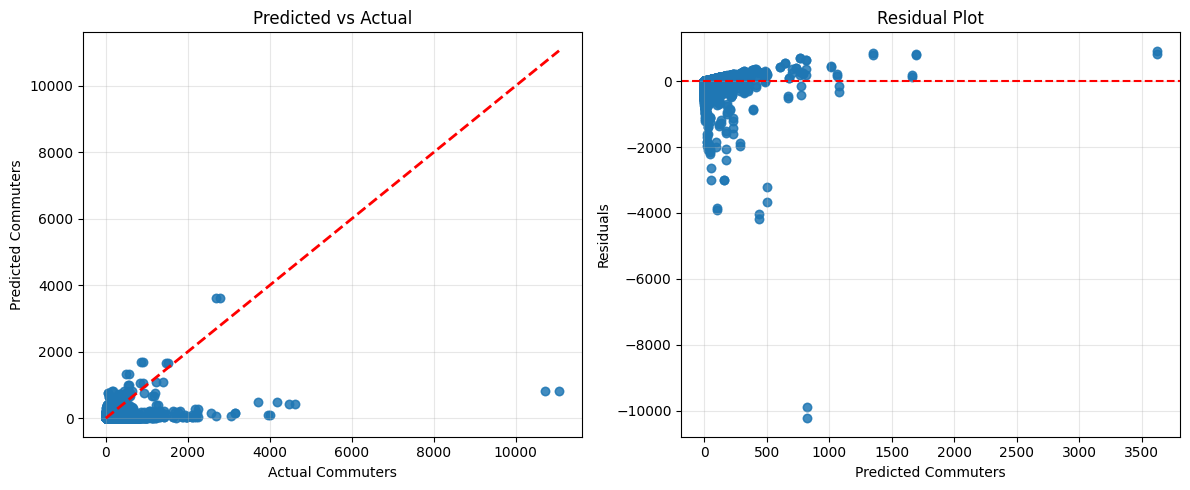

In [89]:
metrics = evaluate_model(y_test, y_pred)

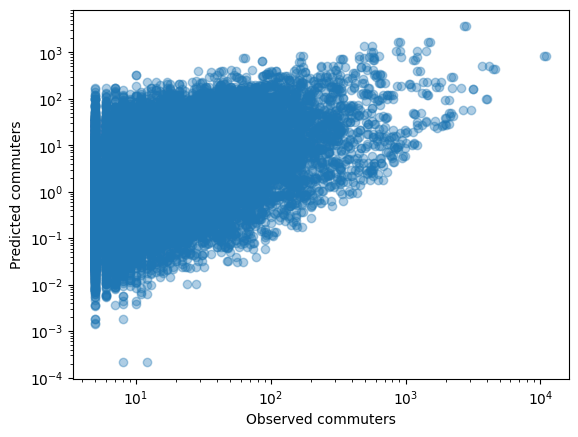

In [90]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Observed commuters")
plt.ylabel("Predicted commuters")
plt.show()


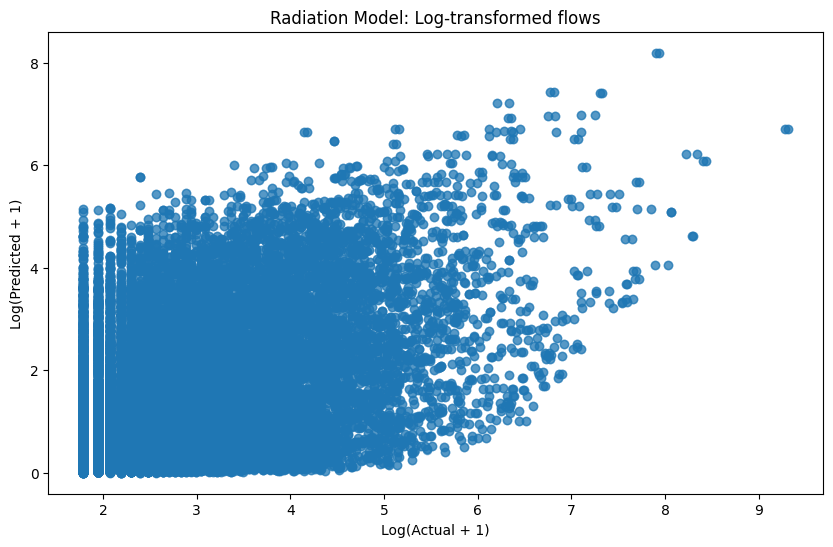

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log1p(y_test), np.log1p(y_pred), alpha=0.5)
plt.xlabel('Log(Actual + 1)')
plt.ylabel('Log(Predicted + 1)')
plt.title('Radiation Model: Log-transformed flows')
plt.show()